In [1]:
%reload_ext autoreload
%autoreload 2

In [226]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import downstream_information
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [216]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## Main analysis

In [344]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_info_v2"
    )

batch_analysis.run(
    sessions,
    save_path,
    downstream_information.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
results = downstream_information.load_results(save_path)

100%|██████████| 110/110 [04:27<00:00,  2.44s/it]


In [218]:
results

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,conditional_entropy,environment,epoch,basepath
0,0.001990,deep_mec,0,16,CA1,MEC,59,87,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
1,0.011604,deep_mec,0,17,CA1,MEC,59,89,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
2,0.000123,deep_mec,0,18,CA1,MEC,59,90,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
3,0.017300,deep_mec,0,19,CA1,MEC,59,91,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
4,0.001394,deep_mec,0,20,CA1,MEC,59,92,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
...,...,...,...,...,...,...,...,...,...,...,...,...
556729,NaN,sup_pfc,31,10,CA1sr,PFC,47,17,2.078217,sleep,post,Z:\Data\ORproject\OR18\day2
556730,NaN,sup_pfc,31,11,CA1sr,PFC,47,18,1.765958,sleep,post,Z:\Data\ORproject\OR18\day2
556731,NaN,sup_pfc,31,12,CA1sr,PFC,47,19,1.325934,sleep,post,Z:\Data\ORproject\OR18\day2
556732,NaN,sup_pfc,31,13,CA1sr,PFC,47,20,1.400277,sleep,post,Z:\Data\ORproject\OR18\day2


In [245]:
# results.loc[results.mutual_info == 0, "mutual_info"] = np.nan

In [244]:
results.describe()

,mutual_info,reference_id,target_id,reference_uid,target_uid,conditional_entropy
count,278367.000000,556734.000000,556734.000000,556734.000000,556734.000000,278367.000000
mean,0.096097,108.848786,130.150654,187.499035,225.443425,1.064532
std,0.145453,74.146949,81.981350,130.538103,137.297610,0.745694
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.017269,34.000000,62.000000,67.000000,117.000000,0.458473
50%,0.053002,111.000000,117.000000,189.000000,218.000000,0.976397
75%,0.115145,174.000000,197.000000,279.000000,307.000000,1.541524
max,2.550341,255.000000,318.000000,743.000000,743.000000,4.988696


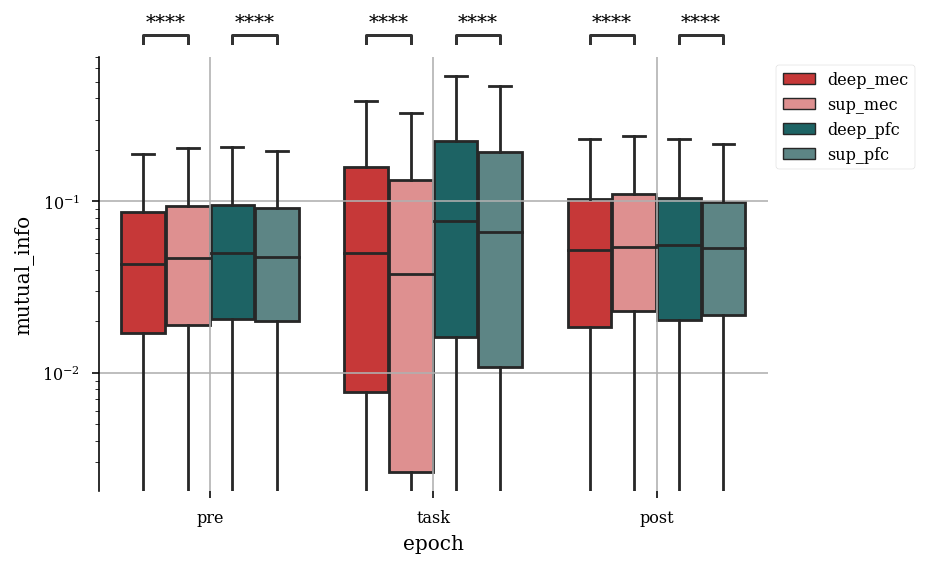

In [252]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="mutual_info",
#     hue_order=group_colors.keys(),
#     data=results,
#     dodge=True,
#     size=2,
# )

plt.yscale("log")

plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.despine(bottom=True)
# plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

box_pairs = [
    (("pre", "deep_mec"), ("pre", "sup_mec")),
    (("pre", "deep_pfc"), ("pre", "sup_pfc")),
    (("task", "deep_mec"), ("task", "sup_mec")),
    (("task", "deep_pfc"), ("task", "sup_pfc")),
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="epoch",
    y="mutual_info",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


<AxesSubplot:xlabel='epoch', ylabel='mutual_info'>

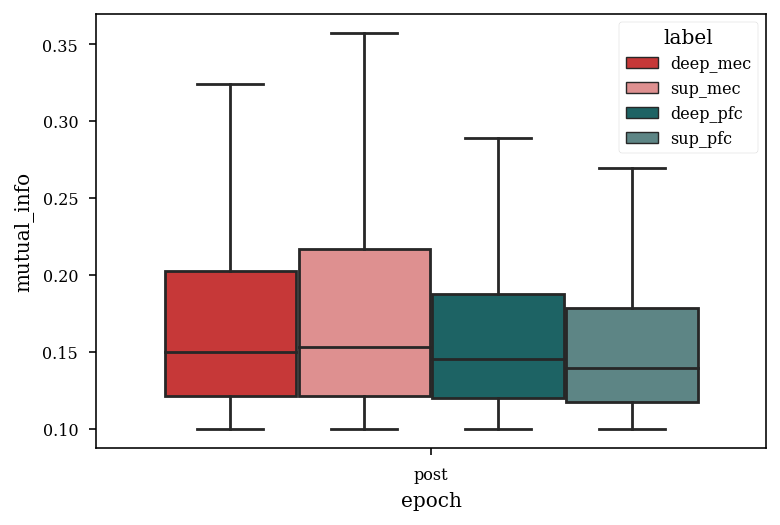

In [301]:
# results["mutual_info_trans"] = (results.mutual_info+.1)**-1.060606
sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[(results.epoch == "post") & (results.mutual_info > 0.1) & (~np.isnan(results.mutual_info))],
    showfliers=False,
)
# plt.yscale("log")
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="mutual_info_trans",
#     hue_order=group_colors.keys(),
#     data=results,
#     dodge=True,
#     color="k",
#     alpha=.1
# )

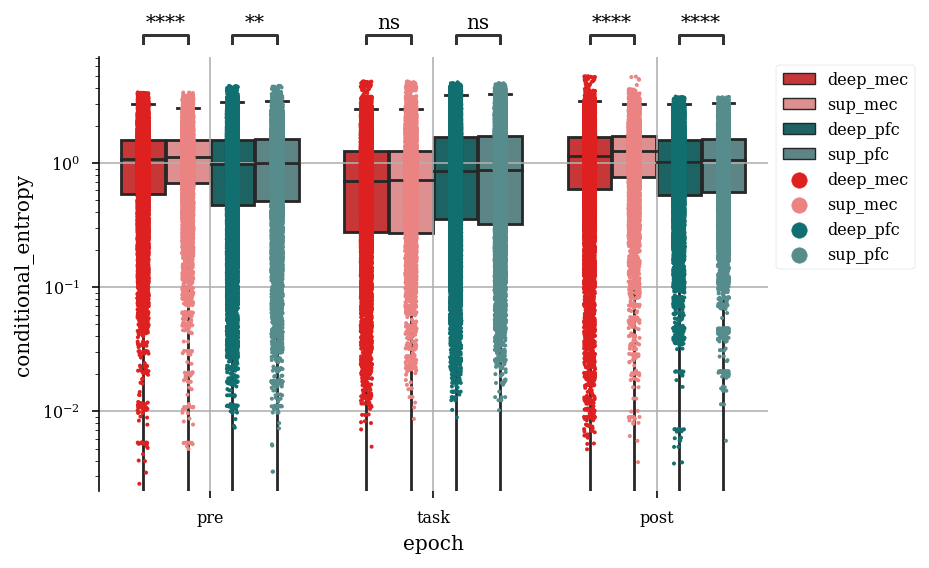

In [239]:
sns.boxplot(
    x="epoch",
    hue="label",
    y="conditional_entropy",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    hue="label",
    y="conditional_entropy",
    hue_order=group_colors.keys(),
    data=results,
    dodge=True,
    size=2,
)

plt.yscale("log")
plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.despine(bottom=True)

box_pairs = [
    (("pre", "deep_mec"), ("pre", "sup_mec")),
    (("pre", "deep_pfc"), ("pre", "sup_pfc")),
    (("task", "deep_mec"), ("task", "sup_mec")),
    (("task", "deep_pfc"), ("task", "sup_pfc")),
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="epoch",
    y="conditional_entropy",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()

<AxesSubplot:>

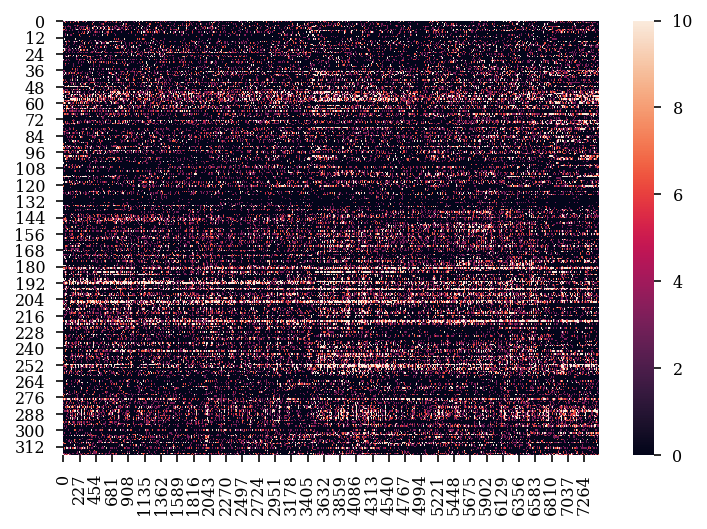

In [305]:
sns.heatmap(ripple_mat,vmax=10)

In [330]:
import multiprocessing
from joblib import Parallel, delayed

def shuffle_patterns(patterns):
    return np.random.permutation(patterns.flatten()).reshape(patterns.shape)
n_shuffles = 100
parallel = True


if parallel:
    num_cores = multiprocessing.cpu_count()
    si_shuffles = Parallel(n_jobs=num_cores)(
        delayed(downstream_information.pairwise_info)(shuffle_patterns(ripple_mat),return_index=False) for _ in range(n_shuffles)
    )
else:
    si_shuffles = [downstream_information.pairwise_info(shuffle_patterns(ripple_mat),return_index=False) for _ in range(n_shuffles)]

In [326]:
si_shuffles

[array([0.03859997, 0.03131936, 0.03387092, ..., 0.02747563, 0.02799268,
        0.03484818]),
 array([0.03023995, 0.02986501, 0.03252053, ..., 0.03374225, 0.02952352,
        0.03315548]),
 array([0.03144227, 0.02965873, 0.03155078, ..., 0.03113477, 0.03392977,
        0.03472492])]

In [332]:
si = downstream_information.pairwise_info(ripple_mat,return_index=False)
_, pvalues = functions.get_significant_events(si, np.array(si_shuffles))

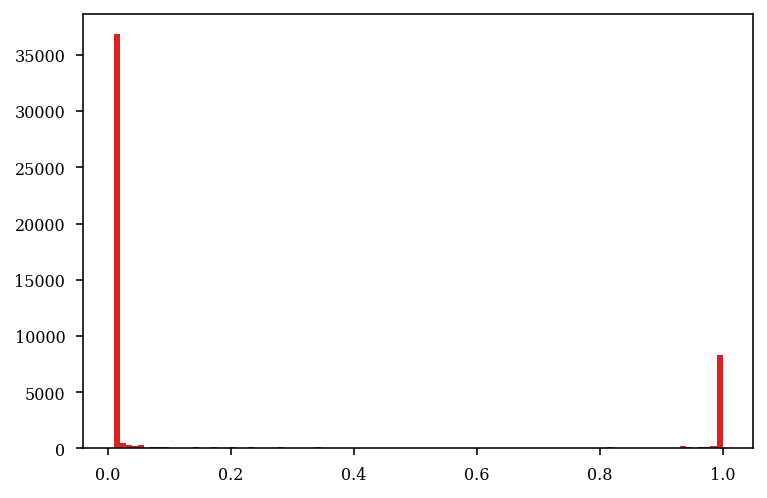

In [336]:
plt.hist(pvalues,100)
plt.show()

(0.02205101492586148,
 0.04533178562263651,
 0.020583198157006887,
 0.04519780921010079)

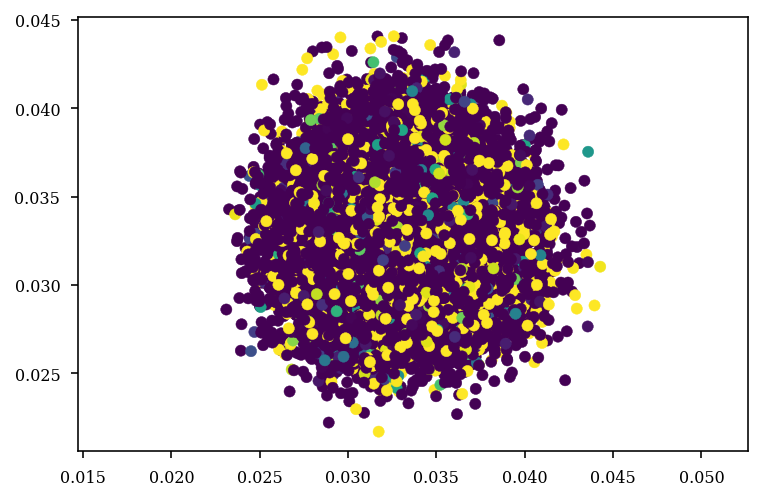

In [337]:
plt.scatter(si_shuffles[0], si_shuffles[1],c=pvalues)
plt.axis("equal")

In [274]:
# add animal id to results

results["animal_id"] = results.basepath.map(dict([(basepath, loading.get_animal_id(basepath)) for basepath in results.basepath.unique()]))
results.animal_id.unique()

array(['AYA7', 'AYA9', 'EE', 'HMC1', 'ec013', 'ec014', 'Kenji', 'ec016',
       'i01_m', 'OR18'], dtype=object)

In [275]:
results.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_information_results.csv")

# Testing below

In [8]:
from pyinform import conditional_entropy,entropy_rate,mutual_info,transfer_entropy

# xs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]
# ys = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]
# conditional_entropy(xs,ys) 

In [5]:
basepath = r"Z:\Data\HMC1\day13"
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="PFC|CA1|MEC")

In [6]:
ripples_df = loading.load_ripples_events(basepath)
ripples = nel.EpochArray(np.array([ripples_df.start,ripples_df.stop]).T).expand(0.05,direction="start").expand(0.2,direction="stop")
# ripples.expand(0.05,direction="start")

ripple_mat = functions.get_participation(st.data,ripples.starts,ripples.stops,par_type="firing_rate")
ripple_mat.shape

(319, 7471)

In [52]:
import itertools


def pairwise_info(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.combinations(x, 2)))
    mi = []
    ce = []
    for pair in pairs:
        mi.append(mutual_info(X[pair[0], :], X[pair[1], :]))
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(mi),np.hstack(ce), pairs

def pairwise_conditional_entropy(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.product(x,repeat=2)))
    ce = []
    for pair in pairs:
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(ce), pairs

mi, ce, pairs_mi= pairwise_info(ripple_mat)
ce, pairs_ce = pairwise_conditional_entropy(ripple_mat)


In [103]:
def find_pairs(cm,pairs,pair_1,pair_2,layer):
    pairs_idx = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_2))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_2))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
    )
    return pairs_idx
deep_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Deep")
deep_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Deep")
sup_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Superficial")
sup_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Superficial")

In [140]:


def make_df(ce,pairs,cm,y_label=None):
    deep_pfc = find_pairs(cm,pairs,"CA1","PFC","Deep")
    deep_mec = find_pairs(cm,pairs,"CA1","MEC","Deep")
    sup_pfc = find_pairs(cm,pairs,"CA1","PFC","Superficial")
    sup_mec = find_pairs(cm,pairs,"CA1","MEC","Superficial")

    df = pd.DataFrame()

    df[y_label] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
    df["label"] = np.hstack(
        [
            ["deep_pfc"] * len(ce[deep_pfc]),
            ["deep_mec"] * len(ce[deep_mec]),
            ["sup_pfc"] * len(ce[sup_pfc]),
            ["sup_mec"] * len(ce[sup_mec]),
        ]
    )
    df["reference_id"] = np.hstack(
        [
            pairs[deep_pfc, 0],
            pairs[deep_mec, 0],
            pairs[sup_pfc, 0],
            pairs[sup_mec, 0],
        ]
    )

    df["target_id"] = np.hstack(
        [
            pairs[deep_pfc, 1],
            pairs[deep_mec, 1],
            pairs[sup_pfc, 1],
            pairs[sup_mec, 1],
        ]
    )

    df["reference"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 0]],
            cm.brainRegion.iloc[pairs[deep_mec, 0]],
            cm.brainRegion.iloc[pairs[sup_pfc, 0]],
            cm.brainRegion.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 1]],
            cm.brainRegion.iloc[pairs[deep_mec, 1]],
            cm.brainRegion.iloc[pairs[sup_pfc, 1]],
            cm.brainRegion.iloc[pairs[sup_mec, 1]],
        ]
    )
    df["reference_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 0]],
            cm.UID.iloc[pairs[deep_mec, 0]],
            cm.UID.iloc[pairs[sup_pfc, 0]],
            cm.UID.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 1]],
            cm.UID.iloc[pairs[deep_mec, 1]],
            cm.UID.iloc[pairs[sup_pfc, 1]],
            cm.UID.iloc[pairs[sup_mec, 1]],
        ]
    )
    return df


In [113]:
conditional_entropy_df = make_df(ce,pairs_ce,cm,"conditional_entropy")
conditional_entropy_df.loc[~conditional_entropy_df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan
conditional_entropy_df.dropna(inplace=True)
conditional_entropy_df

,conditional_entropy,label,reference_id,target_id,reference,target,reference_uid,target_uid
11205,1.360668,deep_pfc,135,0,CA1so,PFC,272,1
11206,0.994142,deep_pfc,135,1,CA1so,PFC,272,2
11207,0.942368,deep_pfc,135,2,CA1so,PFC,272,3
11208,1.533153,deep_pfc,135,3,CA1so,PFC,272,4
11209,1.537234,deep_pfc,135,4,CA1so,PFC,272,6
...,...,...,...,...,...,...,...,...
45517,0.310773,sup_mec,246,314,CA1sr,MEC,420,540
45518,0.800484,sup_mec,246,315,CA1sr,MEC,420,541
45519,0.641952,sup_mec,246,316,CA1sr,MEC,420,542
45520,1.954237,sup_mec,246,317,CA1sr,MEC,420,546


In [114]:
mutual_info_df = make_df(mi,pairs_mi,cm,"mutual_info")

mutual_info_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283
...,...,...,...,...,...,...,...,...
23953,0.026522,sup_mec,246,314,CA1sr,MEC,420,540
23954,0.070829,sup_mec,246,315,CA1sr,MEC,420,541
23955,0.057868,sup_mec,246,316,CA1sr,MEC,420,542
23956,0.209924,sup_mec,246,317,CA1sr,MEC,420,546


In [115]:
test_df = pd.concat([mutual_info_df, conditional_entropy_df],ignore_index=True)
test_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,conditional_entropy
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272,NaN
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274,NaN
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279,NaN
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281,NaN
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283,NaN
...,...,...,...,...,...,...,...,...,...
47911,NaN,sup_mec,246,314,CA1sr,MEC,420,540,0.310773
47912,NaN,sup_mec,246,315,CA1sr,MEC,420,541,0.800484
47913,NaN,sup_mec,246,316,CA1sr,MEC,420,542,0.641952
47914,NaN,sup_mec,246,317,CA1sr,MEC,420,546,1.954237


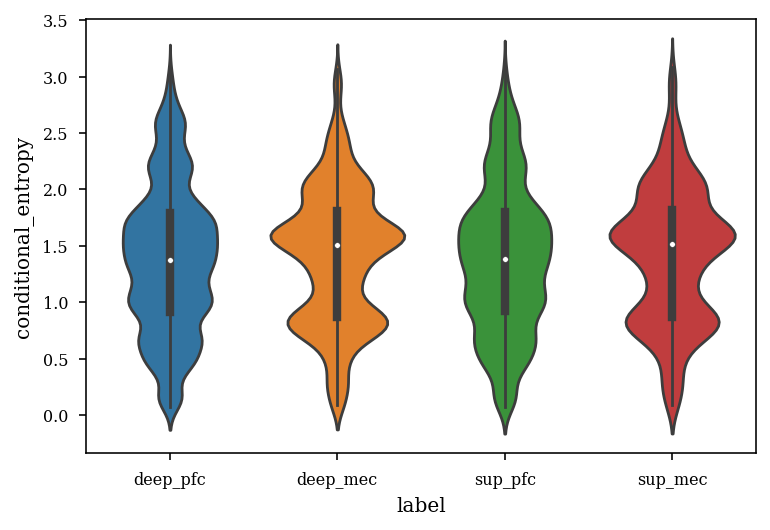

<AxesSubplot:xlabel='label', ylabel='mutual_info'>

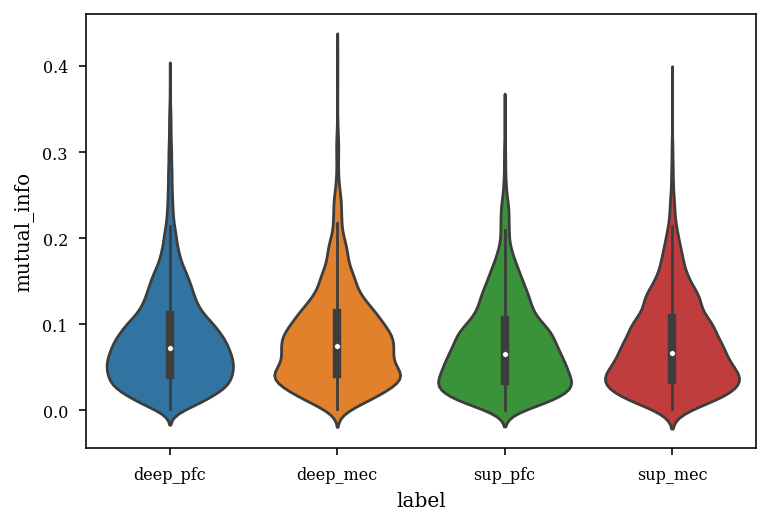

In [116]:
sns.violinplot(x="label", y="conditional_entropy", data=test_df)
plt.show()
sns.violinplot(x="label", y="mutual_info", data=test_df)


<AxesSubplot:xlabel='label', ylabel='conditional_entropy'>

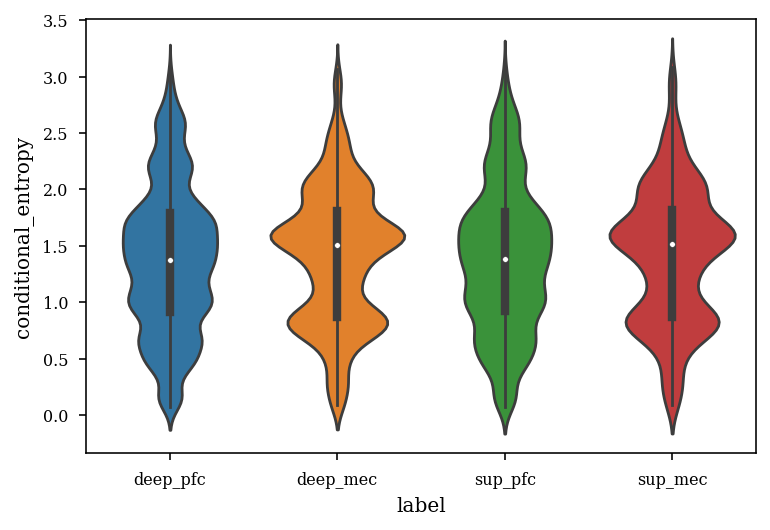

In [54]:
sns.violinplot(x="label", y="conditional_entropy", data=df)

In [38]:
deep_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

deep_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

sup_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

sup_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

In [12]:
df = pd.DataFrame()
df["mutual_info"] = np.hstack([mi[deep_pfc], mi[deep_mec], mi[sup_pfc], mi[sup_mec]])
df["conditional_entropy"] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
df["label"] = np.hstack(
    [
        ["deep_pfc"] * len(mi[deep_pfc]),
        ["deep_mec"] * len(mi[deep_mec]),
        ["sup_pfc"] * len(mi[sup_pfc]),
        ["sup_mec"] * len(mi[sup_mec]),
    ]
)
df["reference"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 0]],
        cm.brainRegion.iloc[pairs[deep_mec, 0]],
        cm.brainRegion.iloc[pairs[sup_pfc, 0]],
        cm.brainRegion.iloc[pairs[sup_mec, 0]],
    ]
)

df["target"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 1]],
        cm.brainRegion.iloc[pairs[deep_mec, 1]],
        cm.brainRegion.iloc[pairs[sup_pfc, 1]],
        cm.brainRegion.iloc[pairs[sup_mec, 1]],
    ]
)

df["reference_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 0]],
        cm.UID.iloc[pairs[deep_mec, 0]],
        cm.UID.iloc[pairs[sup_pfc, 0]],
        cm.UID.iloc[pairs[sup_mec, 0]],
    ]
)

df["target_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 1]],
        cm.UID.iloc[pairs[deep_mec, 1]],
        cm.UID.iloc[pairs[sup_pfc, 1]],
        cm.UID.iloc[pairs[sup_mec, 1]],
    ]
)
df


,mutual_info,conditional_entropy,label,reference,target,reference_uid,target_uid
0,0.067176,1.429065,deep_pfc,PFC,CA1so,1,272
1,0.078890,1.717974,deep_pfc,PFC,CA1so,1,274
2,0.084916,1.647071,deep_pfc,PFC,CA1so,1,279
3,0.043270,1.159592,deep_pfc,PFC,CA1so,1,281
4,0.056667,1.454070,deep_pfc,PFC,CA1so,1,283
...,...,...,...,...,...,...,...
23953,0.026522,0.310773,sup_mec,CA1sr,MEC,420,540
23954,0.070829,0.800484,sup_mec,CA1sr,MEC,420,541
23955,0.057868,0.641952,sup_mec,CA1sr,MEC,420,542
23956,0.209924,1.954237,sup_mec,CA1sr,MEC,420,546


In [18]:
df.loc[~df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan

<AxesSubplot:xlabel='mutual_info', ylabel='conditional_entropy'>

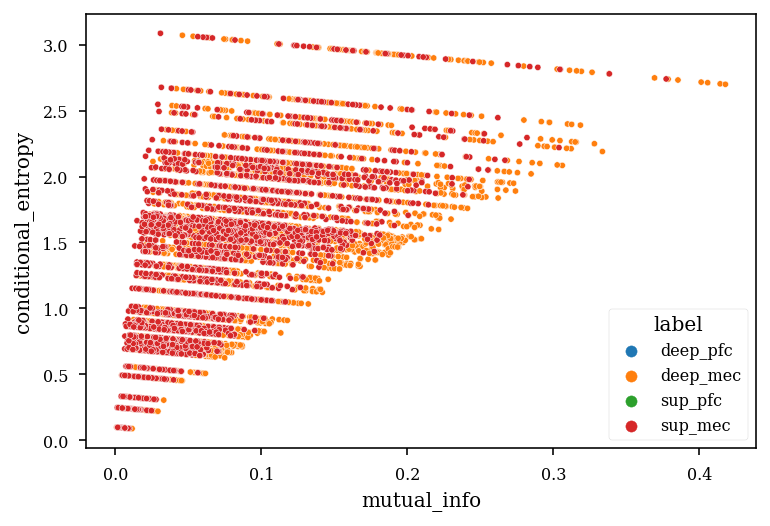

In [19]:
sns.scatterplot(x="mutual_info", y="conditional_entropy", hue="label", data=df,s=10)

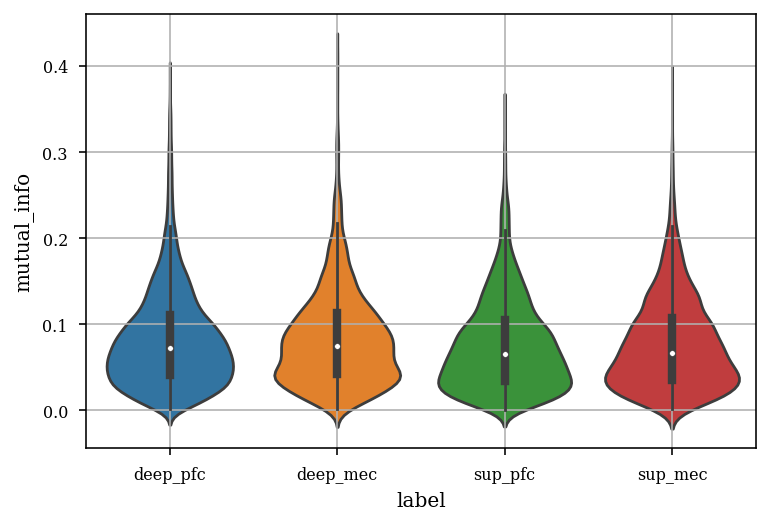

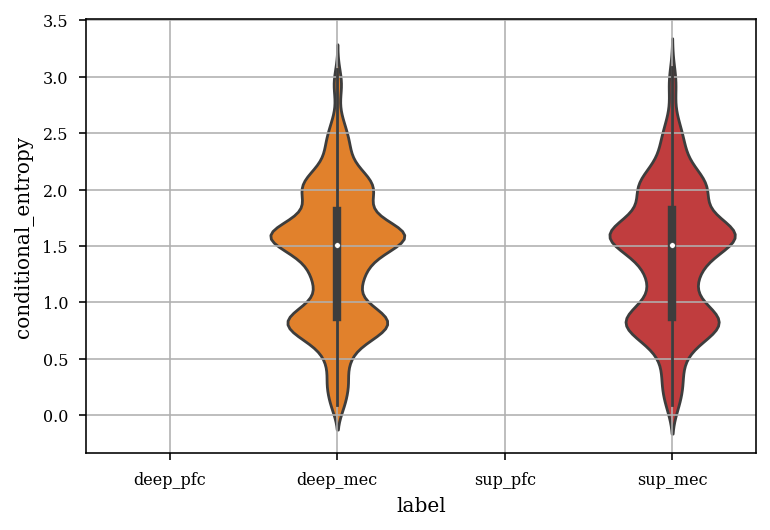

In [20]:
sns.violinplot(x="label", y="mutual_info", data=df)
# sns.stripplot(x="label", y="mi", data=df, color="black", size=1)
# plt.yscale("log")
plt.grid()
plt.show()

sns.violinplot(x="label", y="conditional_entropy", data=df)

plt.grid()
plt.show()